# XAI for Sea Ice Roughness from Waveform

This notebook is similar to the previous ones, but it is experimenting XAI on the task of regression on sea ice roughness using waveform features.

We need to install GPY and restart session as we did in our last notebook.

In [12]:
!pip install Gpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


# XAI Neural Network Approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
import ast
from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation
import shap

# Function to parse string representation of waveform array into numeric values
def parse_waveform(waveform_str):
    """Parse the string representation of waveform array into numeric values"""
    cleaned_str = waveform_str.replace('e+', 'e').replace(' ', '')

    try:
        # Use ast.literal_eval for safe evaluation of the string as a list
        waveform_list = ast.literal_eval(cleaned_str)
        return np.array(waveform_list)
    except (SyntaxError, ValueError) as e:
        try:
            # Manual parsing fallback
            values_str = waveform_str.strip('[]').split(',')
            values = []
            for val in values_str:
                val = val.strip()
                if val:  # Skip empty strings
                    values.append(float(val))
            return np.array(values)
        except Exception as e2:
            print(f"Error parsing waveform: {e2}")
            return np.array([])

# ----- Waveform Feature Extraction Functions -----

def extract_waveform_features(waveform):
    """Extract features from a radar waveform as described in the literature"""
    features = {}

    # Normalize waveform for relative measurements
    if np.max(waveform) > 0:
        norm_waveform = waveform / np.max(waveform)
    else:
        norm_waveform = waveform.copy()

    # 1. Leading Edge Width (LEW)
    # Find the positions where the waveform crosses 30% and 70% thresholds on rising edge
    try:
        # Find the maximum position
        max_idx = np.argmax(norm_waveform)

        # Find indexes before the peak where waveform crosses 30% and 70% thresholds
        thresh_30_idx = None
        thresh_70_idx = None

        for i in range(max_idx):
            if norm_waveform[i] <= 0.3 and norm_waveform[i+1] > 0.3:
                # Interpolate to find more precise bin position
                frac = (0.3 - norm_waveform[i]) / (norm_waveform[i+1] - norm_waveform[i])
                thresh_30_idx = i + frac
            if norm_waveform[i] <= 0.7 and norm_waveform[i+1] > 0.7:
                # Interpolate to find more precise bin position
                frac = (0.7 - norm_waveform[i]) / (norm_waveform[i+1] - norm_waveform[i])
                thresh_70_idx = i + frac

        # If thresholds weren't found before peak, use default values
        if thresh_30_idx is None or thresh_70_idx is None:
            features['lew'] = np.nan
        else:
            features['lew'] = thresh_70_idx - thresh_30_idx
    except:
        features['lew'] = np.nan

    # 2. Waveform Maximum (Wm)
    features['wm'] = np.max(waveform)

    # 3. Trailing Edge Decline (Ted)
    try:
        # Exponential decay function for fitting
        def exp_decay(x, a, b):
            return a * np.exp(-b * x)

        max_idx = np.argmax(waveform)
        trailing_edge = waveform[max_idx:]

        if len(trailing_edge) > 3:  # Need at least a few points for fitting
            x_data = np.arange(len(trailing_edge))

            # Avoid curve_fit errors by ensuring positive values
            trailing_edge_pos = np.maximum(trailing_edge, 1e-10)

            # Initial guess for parameters
            p0 = [trailing_edge_pos[0], 0.1]

            try:
                # Fit exponential decay to trailing edge
                popt, _ = curve_fit(exp_decay, x_data, trailing_edge_pos, p0=p0, maxfev=1000)
                features['ted'] = popt[1]  # Decay rate parameter
            except:
                features['ted'] = np.nan
        else:
            features['ted'] = np.nan
    except:
        features['ted'] = np.nan

    # 4. Waveform Noise (Wn) - MAD of trailing edge residuals
    try:
        max_idx = np.argmax(waveform)
        trailing_edge = waveform[max_idx:]

        if len(trailing_edge) > 3 and 'ted' in features and not np.isnan(features['ted']):
            # Using the fitted parameters from Ted
            x_data = np.arange(len(trailing_edge))
            fitted_values = features['wm'] * np.exp(-features['ted'] * x_data)

            # Calculate residuals
            residuals = trailing_edge - fitted_values

            # MAD of residuals
            features['wn'] = median_abs_deviation(residuals, scale=1.0)
        else:
            features['wn'] = np.nan
    except:
        features['wn'] = np.nan

    # 5. Waveform Width (Ww)
    # Count bins with power > 0
    features['ww'] = np.sum(waveform > 0)

    # 6. Leading Edge Slope (Les)
    try:
        max_idx = np.argmax(norm_waveform)

        # Find bins where waveform exceeds 30% of max
        thresh_30_idx = None
        for i in range(max_idx):
            if norm_waveform[i] <= 0.3 and norm_waveform[i+1] > 0.3:
                thresh_30_idx = i
                break

        if thresh_30_idx is not None:
            # Calculate difference between max bin and first 30% threshold bin
            features['les'] = max_idx - thresh_30_idx
        else:
            features['les'] = np.nan
    except:
        features['les'] = np.nan

    # 7. Trailing Edge Slope (Tes)
    try:
        max_idx = np.argmax(norm_waveform)

        # Find last bin where waveform exceeds 30% of max
        thresh_30_idx = None
        for i in range(len(norm_waveform)-1, max_idx, -1):
            if norm_waveform[i] <= 0.3 and norm_waveform[i-1] > 0.3:
                thresh_30_idx = i
                break

        if thresh_30_idx is not None:
            # Calculate difference between last 30% threshold bin and max bin
            features['tes'] = thresh_30_idx - max_idx
        else:
            features['tes'] = np.nan
    except:
        features['tes'] = np.nan

    # 8. Pulse Peakiness (PP) - common waveform feature in literature
    try:
        features['pp'] = features['wm'] / np.mean(waveform)
    except:
        features['pp'] = np.nan

    # 9. Max position (relative bin where the maximum occurs)
    try:
        features['max_pos'] = np.argmax(waveform) / len(waveform)
    except:
        features['max_pos'] = np.nan

    return features

def extract_waveforms_and_features(roughness, target_column):
    """Process all waveforms and extract features"""
    # Lists to store data
    feature_list = []
    target_list = []
    valid_indices = []
    raw_waveforms = []

    print("Extracting features from waveforms...")

    # Process each row
    for idx, row in roughness.iterrows():
        if idx % 500 == 0:
            print(f"Processing row {idx}/{len(roughness)}...")

        try:
            # Get the waveform and class
            waveform_str = str(row['Matched_Waveform_20_Ku'])
            waveform_array = parse_waveform(waveform_str)

            # Get class label
            class_label = int(row[target_column])

            # Extract features if valid waveform
            if len(waveform_array) > 0:
                # Extract features
                features = extract_waveform_features(waveform_array)

                # Skip if any feature is NaN
                if np.any(np.isnan(list(features.values()))):
                    continue

                # Store data
                feature_list.append(list(features.values()))
                target_list.append(class_label)
                valid_indices.append(idx)
                raw_waveforms.append(waveform_array)

        except Exception as e:
            if idx < 5:  # Print first few errors
                print(f"Error processing row {idx}: {e}")
            continue

    # Convert to numpy arrays
    X_features = np.array(feature_list)
    y = np.array(target_list)
    X_raw = np.array(raw_waveforms)

    # Create feature names
    feature_names = ['Leading Edge Width', 'Waveform Maximum',
                     'Trailing Edge Decline', 'Waveform Noise',
                     'Waveform Width', 'Leading Edge Slope',
                     'Trailing Edge Slope', 'Pulse Peakiness',
                     'Max Position']

    return X_features, y, X_raw, valid_indices, feature_names



       3A=0_3B=1  Orbit_#  Segment_#     Datenumber   Latitude  Longitude  \
0              0        1          1  738977.028790  74.432732 -73.103512   
1              0        1          1  738977.028790  74.435182 -73.109831   
2              0        1          1  738977.028791  74.437633 -73.116151   
3              0        1          1  738977.028791  74.440083 -73.122474   
4              0        1          1  738977.028792  74.442533 -73.128797   
...          ...      ...        ...            ...        ...        ...   
28720          0      843        843  739006.699439  71.763165 -74.486482   
28721          0      843        843  739006.699440  71.760574 -74.491177   
28722          0      843        843  739006.699440  71.757982 -74.495872   
28723          0      843        843  739006.699450  71.711313 -74.580159   
28724          0      843        843  739006.699451  71.708719 -74.584830   

       Radar_Freeboard  Surface_Height_WGS84  Sea_Surface_Height_Interp_WGS

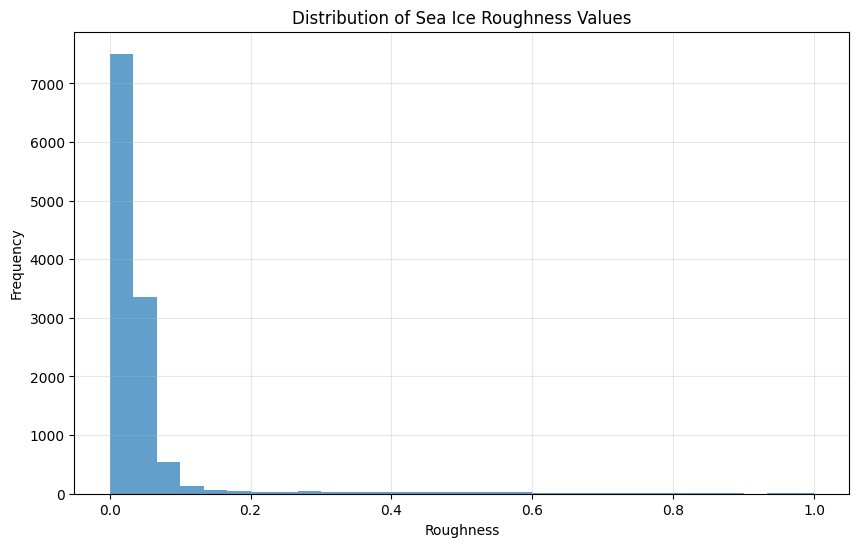

Removed 0 samples with NaN values
Clean feature data shape: (12765, 9)


In [2]:
# ----- Main Processing -----
roughness = pd.read_csv('/content/drive/MyDrive/GEOL0069/2324/Week 9 2025/updated_filtered_matched_uit_sentinel3_L2_alongtrack_2023_04_official.txt')
print(roughness)

print("Starting waveform feature extraction for roughness regression...")

# Define the target column for regression
target_column = 'Sea_Ice_Roughness'
if target_column not in roughness.columns:
    print(f"Warning: {target_column} not found. Available columns: {roughness.columns}")
    print("Please specify a valid roughness column.")
    # You might want to exit here if the roughness column is not found

# Modify the extract_waveforms_and_features function to handle continuous target values
def extract_waveforms_and_features_for_regression(roughness, target_column):
    """Process all waveforms and extract features for regression"""
    # Lists to store data
    feature_list = []
    target_list = []
    valid_indices = []
    raw_waveforms = []

    print("Extracting features from waveforms...")

    # Process each row
    for idx, row in roughness.iterrows():
        if idx % 500 == 0:
            print(f"Processing row {idx}/{len(roughness)}...")

        try:
            # Get the waveform and roughness value
            waveform_str = str(row['Matched_Waveform_20_Ku'])
            waveform_array = parse_waveform(waveform_str)

            # Get roughness value (as float, not int)
            roughness_value = float(row[target_column])

            # Extract features if valid waveform
            if len(waveform_array) > 0:
                # Extract features
                features = extract_waveform_features(waveform_array)

                # Skip if any feature is NaN
                if np.any(np.isnan(list(features.values()))):
                    continue

                # Store data
                feature_list.append(list(features.values()))
                target_list.append(roughness_value)
                valid_indices.append(idx)
                raw_waveforms.append(waveform_array)

        except Exception as e:
            if idx < 5:  # Print first few errors
                print(f"Error processing row {idx}: {e}")
            continue

    # Convert to numpy arrays
    X_features = np.array(feature_list)
    y = np.array(target_list)
    X_raw = np.array(raw_waveforms)

    # Create feature names
    feature_names = ['Leading Edge Width', 'Waveform Maximum',
                     'Trailing Edge Decline', 'Waveform Noise',
                     'Waveform Width', 'Leading Edge Slope',
                     'Trailing Edge Slope', 'Pulse Peakiness',
                     'Max Position']

    return X_features, y, X_raw, valid_indices, feature_names

# Extract features from all waveforms
X_features, y, X_raw, valid_indices, feature_names = extract_waveforms_and_features_for_regression(roughness, target_column)

print(f"Extracted {len(feature_names)} features from {len(X_features)} valid waveforms")
print(f"Features: {feature_names}")
print(f"Feature data shape: {X_features.shape}")
print(f"Roughness value statistics: Min={y.min():.4f}, Max={y.max():.4f}, Mean={y.mean():.4f}, Std={y.std():.4f}")

# Visualize roughness distribution
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, alpha=0.7)
plt.title('Distribution of Sea Ice Roughness Values')
plt.xlabel('Roughness')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Check for NaN values
nan_mask = np.isnan(X_features).any(axis=1)
X_features_clean = X_features[~nan_mask]
y_clean = y[~nan_mask]
X_raw_clean = X_raw[~nan_mask]

print(f"Removed {np.sum(nan_mask)} samples with NaN values")
print(f"Clean feature data shape: {X_features_clean.shape}")

# Split data into training and test sets
# For regression, we don't use stratify since y is continuous
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(
    X_features_clean, y_clean, X_raw_clean,
    test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_nan_mask = np.isnan(X_train_scaled).any(axis=1) | np.isnan(y_train)
test_nan_mask = np.isnan(X_test_scaled).any(axis=1) | np.isnan(y_test)

X_train_scaled = X_train_scaled[~train_nan_mask]
y_train= y_train[~train_nan_mask]
X_test_scaled = X_test_scaled[~test_nan_mask]
y_test = y_test[~test_nan_mask]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0138 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 2/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0087 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 5/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 7/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 8/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 9/100
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0063 - learning_rate: 0.0010

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,949 (136.52 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,300 (91.02 KB)

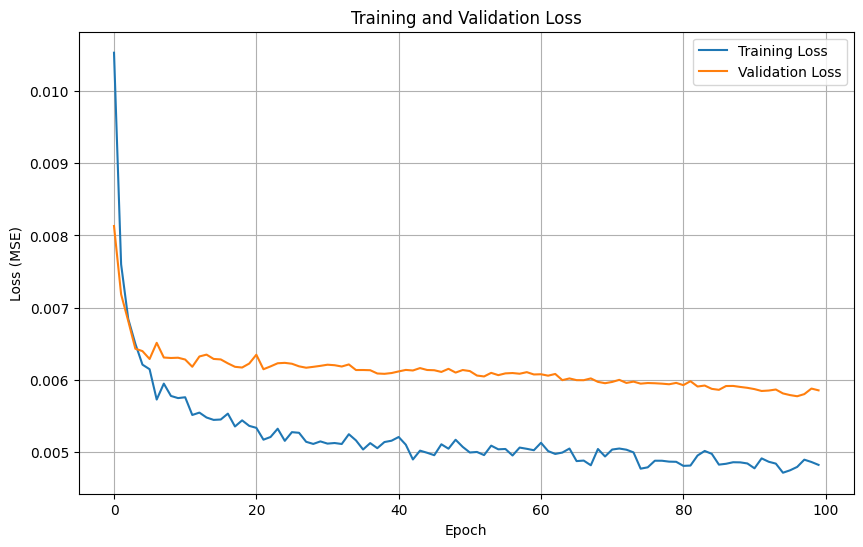

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.005349
Root Mean Squared Error (RMSE): 0.073140
R² Score: 0.429496


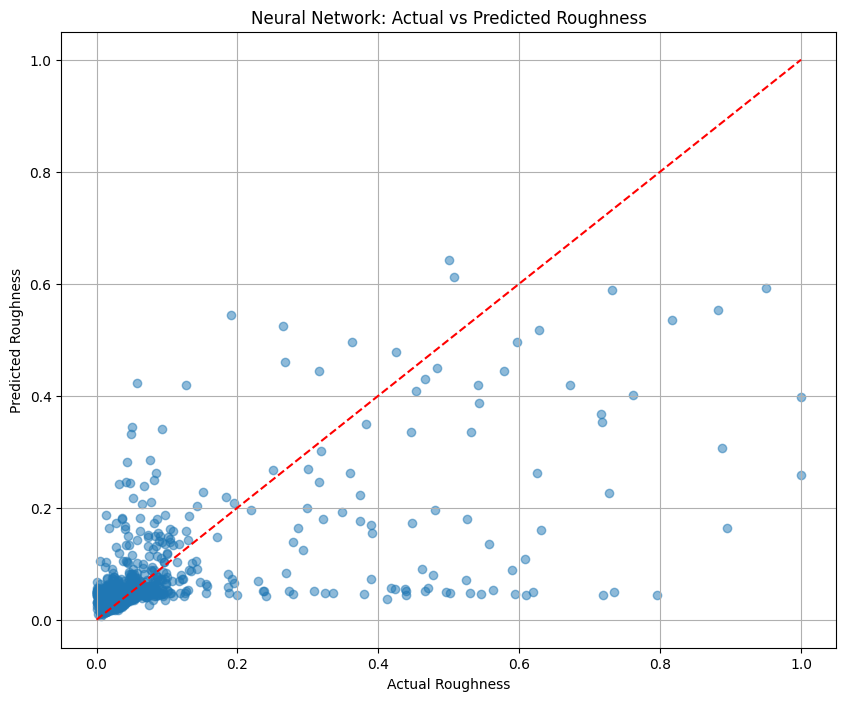

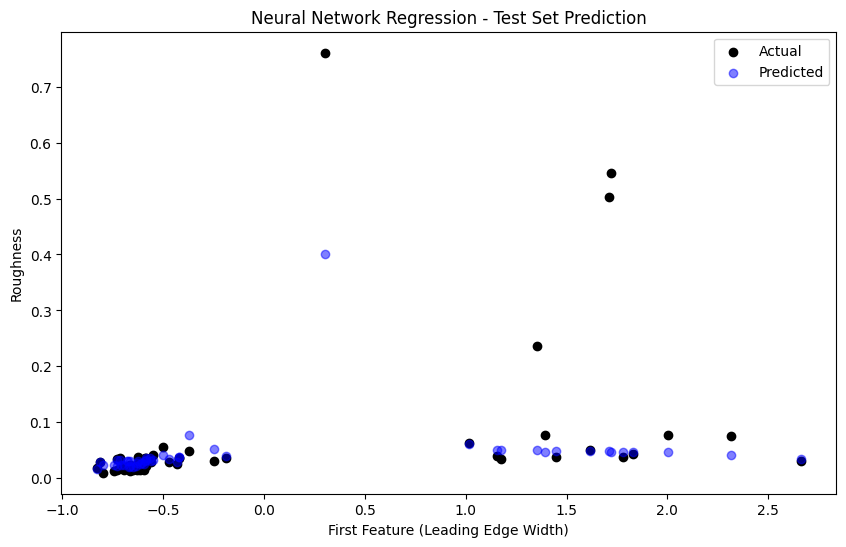

ExactExplainer explainer: 2410it [00:42, 42.48it/s]                          


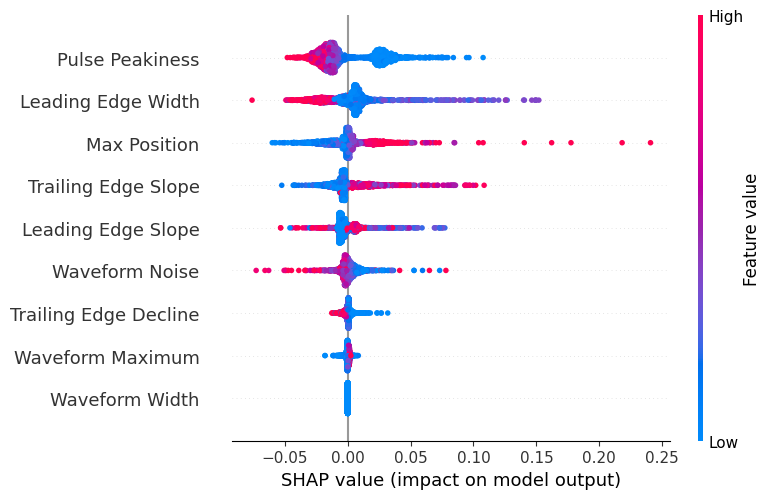

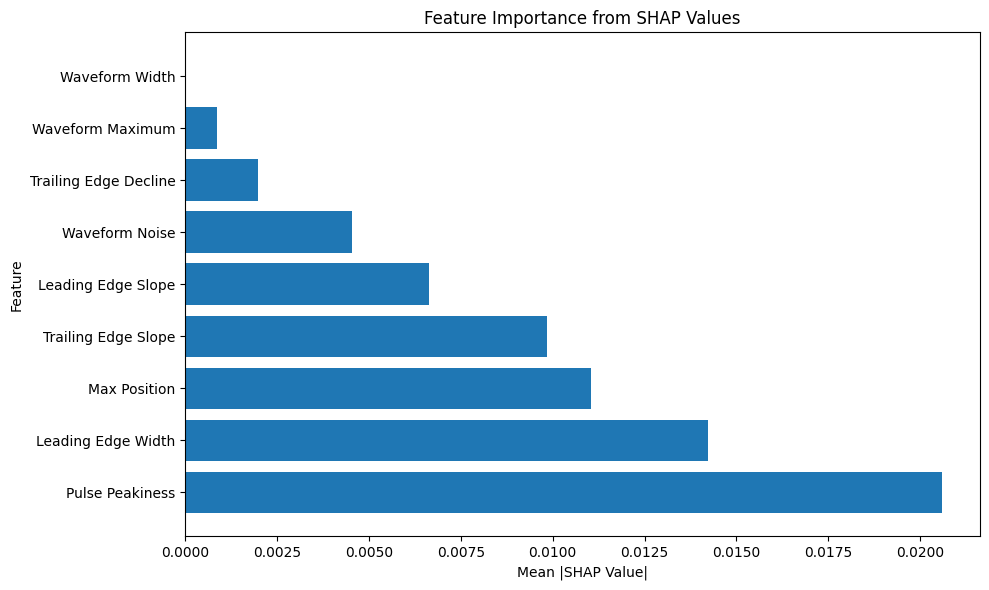

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import shap

# Adjust input shape to match our feature count
input_dim = X_train_scaled.shape[1]

# Build neural network model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Add callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
]

# Train model
history = model_nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Model summary
model_nn.summary()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred = model_nn.predict(X_test_scaled).flatten()

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Neural Network: Actual vs Predicted Roughness')
plt.xlabel('Actual Roughness')
plt.ylabel('Predicted Roughness')
plt.grid(True)
plt.show()



# SHAP analysis
try:
    explainer = shap.Explainer(model_nn, X_train_scaled)
    shap_values = explainer(X_test_scaled)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

    # Get mean absolute SHAP values for feature importance
    feature_importance = np.abs(shap_values.values).mean(0)

    # Create DataFrame of feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Mean |SHAP Value|')
    plt.ylabel('Feature')
    plt.title('Feature Importance from SHAP Values')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in SHAP analysis: {e}")
    print("Trying alternative approach...")

    # Alternative approach - Permutation importance
    from sklearn.inspection import permutation_importance

    result = permutation_importance(
        model_nn, X_test_scaled, y_test,
        n_repeats=10,
        random_state=42
    )

    # Create DataFrame of feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Decrease in Model Performance')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Permutation)')
    plt.tight_layout()
    plt.show()


# XAI Gaussian Processes Approach

=== Training Gaussian Process for Roughness Regression ===
Optimising GP model...


Gaussian Process Results:
Mean Squared Error (MSE): 0.005315
Root Mean Squared Error (RMSE): 0.072905
R² Score: 0.433148

Feature Importance based on ARD Kernel:
                 Feature  Length-Scale  Importance
2  Trailing Edge Decline      8.927677    0.112011
1       Waveform Maximum      8.827020    0.113289
8           Max Position      4.877092    0.205040
3         Waveform Noise      4.053859    0.246679
5     Leading Edge Slope      2.815721    0.355149
6    Trailing Edge Slope      2.738032    0.365226
4         Waveform Width      1.000000    1.000000
0     Leading Edge Width      0.589006    1.697777
7        Pulse Peakiness      0.176909    5.652616


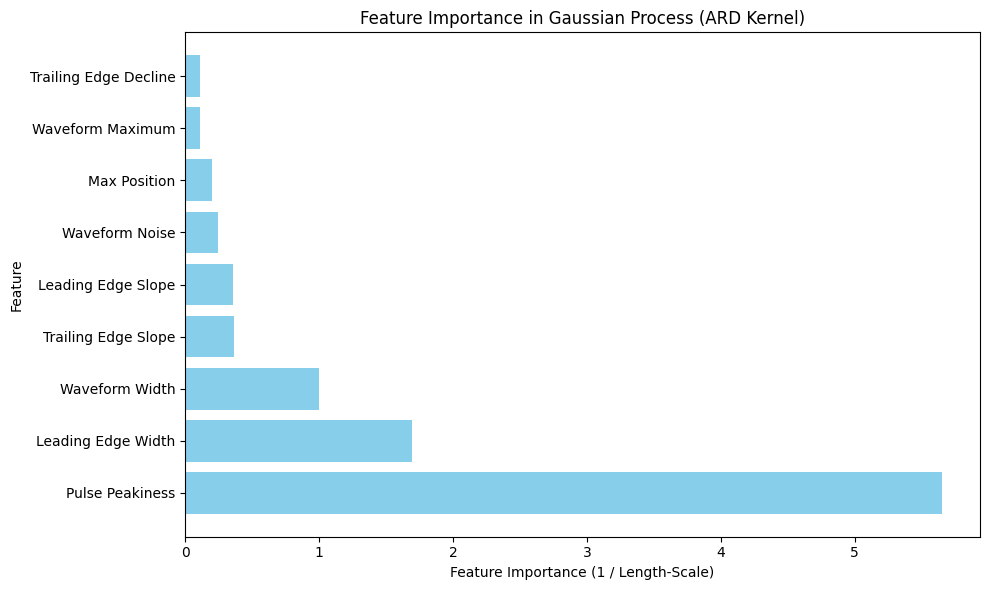

<Figure size 1000x800 with 0 Axes>

In [8]:
import numpy as np
import GPy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

print("=== Training Gaussian Process for Roughness Regression ===")

# For computational efficiency, use a subset of training data
# max_samples = 5000
# if len(X_train_scaled) > max_samples:
#     print(f"Using {max_samples} samples for GP training (out of {len(X_train_scaled)})")
#     indices = np.random.choice(len(X_train_scaled), max_samples, replace=False)
#     X_train_gp = X_train_scaled[indices]
#     y_train_gp = y_train[indices]
# else:
#     X_train_gp = X_train_scaled
#     y_train_gp = y_train


X_train_gp = X_train_scaled
y_train_gp = y_train
# For GP regression with ARD
input_dim = X_train_gp.shape[1]  # Number of features
kernel = GPy.kern.RBF(input_dim=input_dim, ARD=True)

# For regression, we need to reshape y to 2D
y_train_gp_2d = y_train_gp.reshape(-1, 1)

# Number of inducing points (for sparse GP)
num_inducing = min(50, len(X_train_gp))

# Train Sparse Gaussian Process Regression with ARD
gp = GPy.models.SparseGPRegression(
    X_train_gp,
    y_train_gp_2d,
    kernel=kernel,
    num_inducing=num_inducing
)

# Optimise the model
print("Optimising GP model...")
gp.optimize(messages=True)

# Make predictions
y_pred_gp, variance = gp.predict(X_test_scaled)
y_pred_gp = y_pred_gp.flatten()
uncertainty = np.sqrt(variance.flatten())  # Standard deviation

# Evaluate model
mse_gp = mean_squared_error(y_test, y_pred_gp)
rmse_gp = np.sqrt(mse_gp)
r2_gp = r2_score(y_test, y_pred_gp)

print(f"Gaussian Process Results:")
print(f"Mean Squared Error (MSE): {mse_gp:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gp:.6f}")
print(f"R² Score: {r2_gp:.6f}")

# Extract length-scales for each feature (smaller = more important)
length_scales = gp.kern.lengthscale.values

# Compute feature importance as 1 / length-scale
feature_importance_gp = 1 / length_scales

# Create a DataFrame with actual feature names
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Length-Scale": length_scales,
    "Importance": feature_importance_gp
})

# Sort by importance (higher = more important)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)

# Display feature importance DataFrame
print("\nFeature Importance based on ARD Kernel:")
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance (1 / Length-Scale)")
plt.ylabel("Feature")
plt.title("Feature Importance in Gaussian Process (ARD Kernel)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# Plot actual vs predicted with uncertainty
plt.figure(figsize=(10, 8))

# Sort for better visualization
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred_gp[sorted_indices]
uncertainty_sorted = uncertainty[sorted_indices]

